# HubMap- Hacking the Kidney
#### Goal - Mapping the human body at function tissue unit level - detect glomeruli FTUs in kidney

#### Implementation of Kaggle Notebooks - Converting the images to TF-Records

Link 1 - https://www.kaggle.com/marcosnovaes/hubmap-read-data-and-build-tfrecords <br>
Link 2 - https://www.kaggle.com/wrrosa/hubmap-tf-with-tpu-efficientunet-512x512-tfrecs

###### Step 1 - Install useful libraries

In [7]:
import cv2
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shutil
import tensorflow as tf
import glob
import tifffile
import gc

###### You can't read the data as is, convert it into smaller 512x512 tiles and then convert them into TFRecords.
##### Step 2 - Read the csv file

In [8]:
basepath = r'C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data'

##### ID - Image IDs, Corresponding Masks as .tiff and .json files.

##### Step 3 - Read each .tiff file and see its shape

In [9]:
def verify_read(file_list):
    for file_name in file_list:
        baseimage = tifffile.imread(file_name)
        print('img id = {}, shape = {}'.format(file_name,baseimage.shape))
        gc.collect()
        
file_list = glob.glob(basepath+'/tif images/*.tif')
print (file_list)
verify_read(file_list)

['C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Data\\hubmap_colon_data/tif images\\CL_HandE_1234_B004.tif', 'C:\\Users\\soodn\\Downloads\\Naveksha\\Kaggle HuBMAP\\Data\\hubmap_colon_data/tif images\\HandE_B005_CL_b_RGB.tif']


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


img id = C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data/tif images\CL_HandE_1234_B004.tif, shape = (3, 9072, 9408)
img id = C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data/tif images\HandE_B005_CL_b_RGB.tif, shape = (9072, 9408, 3)


##### Step 4 - Read one image nad corresponding mask, visualize it, swap the axis if required.

In [10]:
def read_mask(mask_file, mask_shape):
    read_file = open(mask_file, "r", encoding='utf-8') 
    mask_data = json.load(read_file)
    polys = []
    for index in range(mask_data.__len__()):
        geom = np.array(mask_data[index]['geometry']['coordinates'], dtype=np.int32)
        polys.append(geom)

    mask = np.zeros(mask_shape)
    cv2.fillPoly(mask, polys, 1)
    mask = mask.astype(bool)
    return mask

Original image shape (3, 9072, 9408)
(3, 9072, 9408)
Swaped shape (9072, 9408, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


Original image shape (9072, 9408, 3)
(9072, 9408, 3)


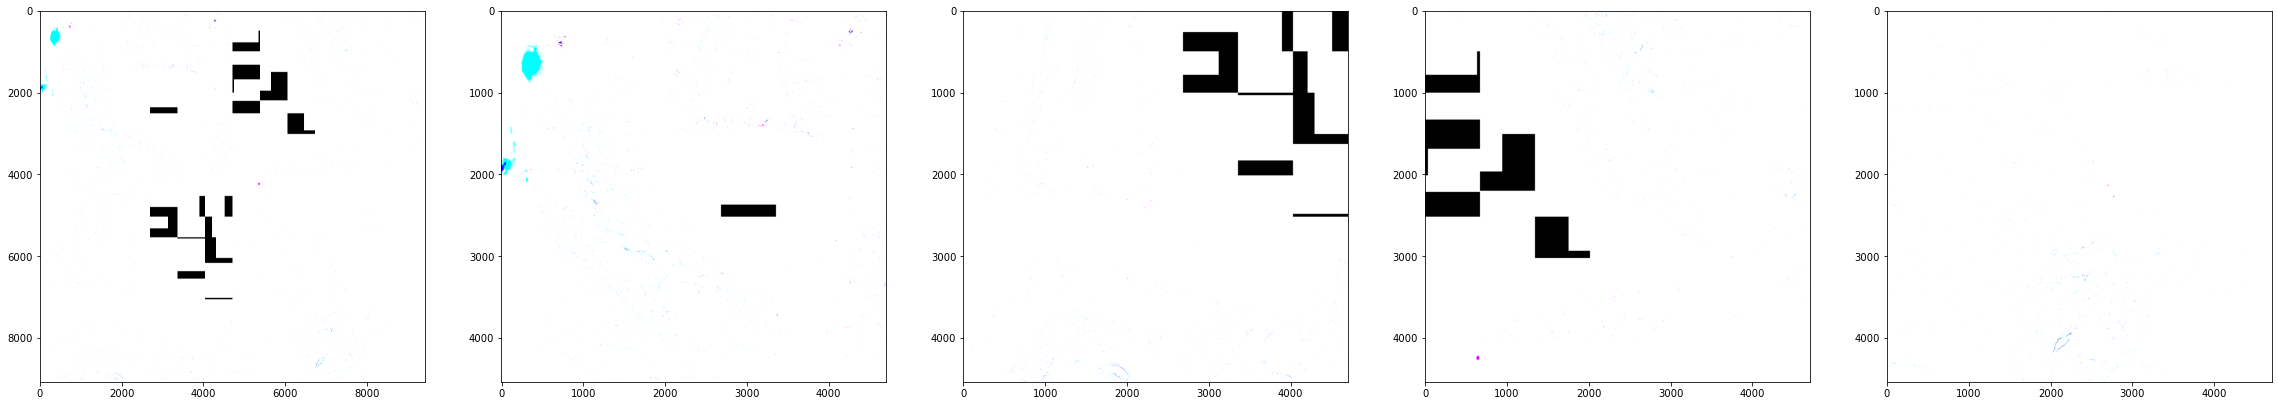

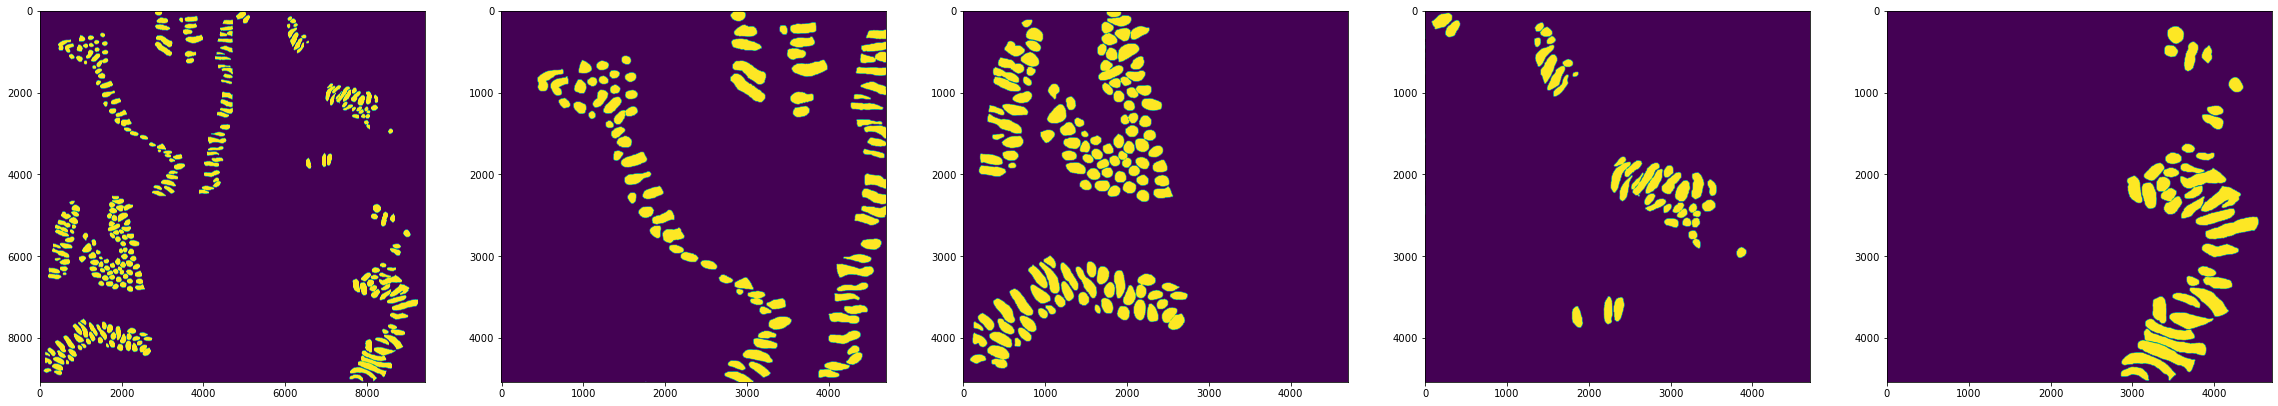

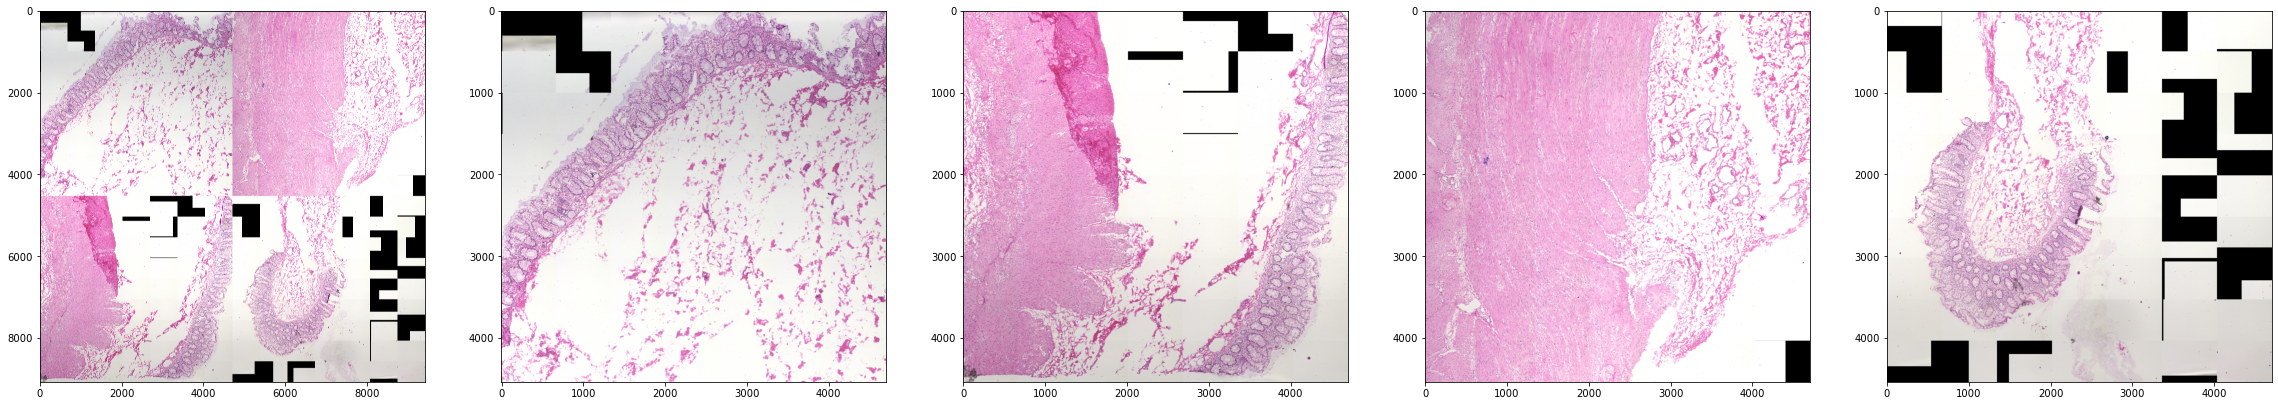

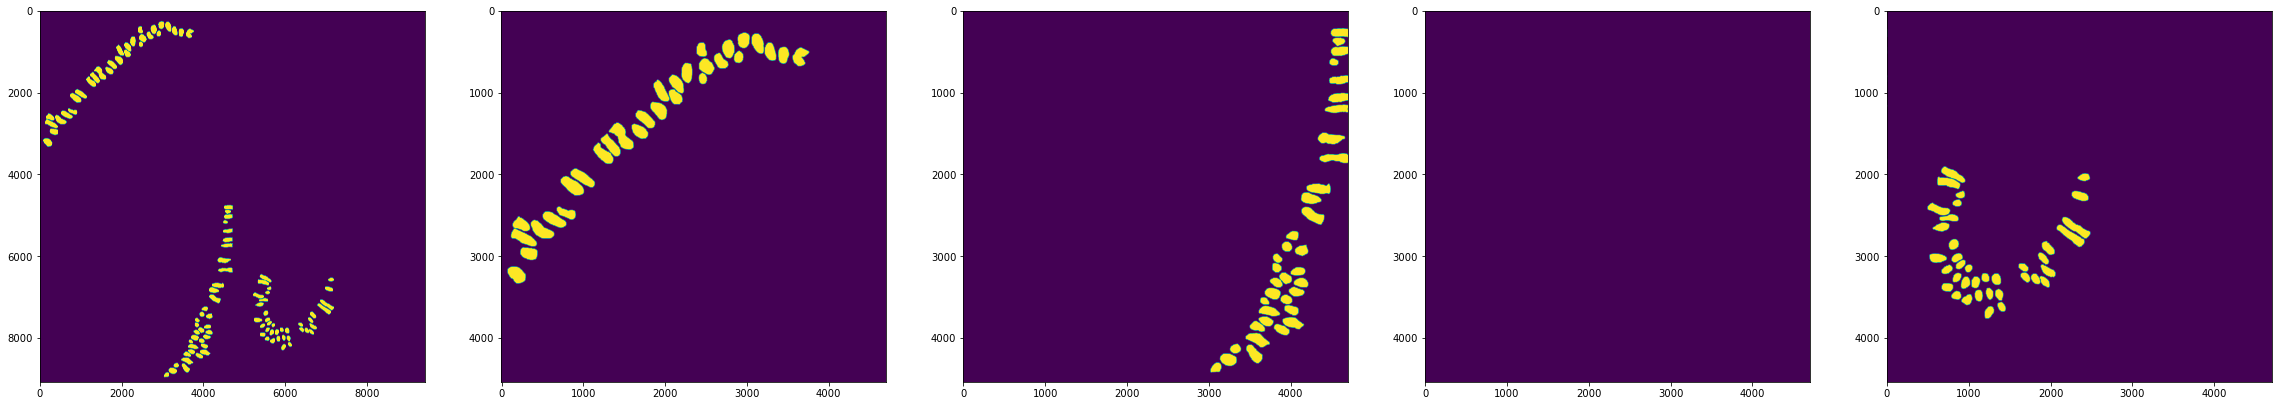

In [15]:
image_ids = ['CL_HandE_1234_B004', 'HandE_B005_CL_b_RGB']
for image, file in zip (image_ids, file_list):
    working_image_path = file
    working_image_id = image
    baseimage = tifffile.imread(working_image_path)
    print ('Original image shape', baseimage.shape)
    baseimage = np.squeeze(baseimage)
    print (baseimage.shape)
    if( baseimage.shape[0] == 3):
        baseimage = baseimage.swapaxes(0,1)
        baseimage = baseimage.swapaxes(1,2)
        print ('Swaped shape',baseimage.shape)

    fig, ax = plt.subplots(1,5,figsize=(40,8))
    ax[0].imshow(baseimage)
    ax[1].imshow(baseimage[0:4536, 0:4704])
    ax[2].imshow(baseimage[4536:9071, 0:4704])
    ax[3].imshow(baseimage[0:4536, 4704:9408])
    ax[4].imshow(baseimage[4536:9072, 4704:9408])
    plt.savefig('OutputColon/'+image+'Colon.png')
    
    working_image_json_mask = basepath+'/Annotations/json/'+working_image_id+'_annotations.json'
    read_file = open(working_image_json_mask, "r") 
    mask_data = json.load(read_file)
    mask_shape = (baseimage.shape[0], baseimage.shape[1])
    mask = read_mask(working_image_json_mask, mask_shape)

    fig, ax = plt.subplots(1,5,figsize=(40,8))
    ax[0].imshow(mask)
    ax[1].imshow(mask[0:4536, 0:4704])
    ax[2].imshow(mask[4536:, 0:4704])
    ax[3].imshow(mask[0:4536, 4704:])
    ax[4].imshow(mask[4536:, 4704:])
    plt.savefig('OutputColon/'+image+'ColonMask.png') 

##### Step 6 - Tile the image into subparts of 512x512 

C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


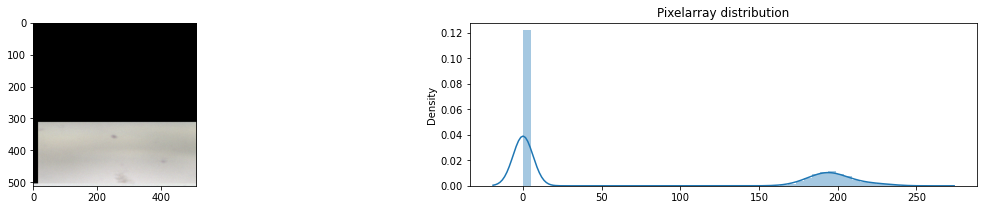

In [16]:
def show_tile_and_mask(baseimage, mask, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos*tile_size
    end_col = start_col + tile_size
    start_row = tile_row_pos * tile_size
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row,:]
    tile_mask = mask[start_col:end_col, start_row:end_row]
    fig, ax = plt.subplots(1,2,figsize=(20,3))
    ax[0].imshow(tile_image)
    ax[1].imshow(tile_mask)

def get_tile(baseimage, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos*tile_size
    end_col = start_col + tile_size
    start_row = tile_row_pos * tile_size
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row,:]
    return tile_image

def get_tile_mask(baseimage, tile_size, tile_col_pos, tile_row_pos):
    start_col = tile_col_pos*tile_size
    end_col = start_col + tile_size
    start_row = tile_row_pos * tile_size
    end_row = start_row + tile_size
    tile_image = baseimage[start_col:end_col, start_row:end_row]
    return tile_image

def show_tile_dist(tile):
    fig, ax = plt.subplots(1,2,figsize=(20,3))
    ax[0].imshow(tile)
    ax[1].set_title("Pixelarray distribution");
    sns.distplot(tile.flatten(), ax=ax[1]);
    
tile_size = 512
tile = get_tile(baseimage, tile_size, 0, 0)
show_tile_dist(tile)

In [34]:
img_hist = np.histogram(tile)
print('histogram = {}'.format(img_hist[0]))
print('histogram_lowpass = {}'.format(np.sum(img_hist[0][0:4])))

histogram = [488448      0      0      0      0     37  23962 189423  75837   8725]
histogram_lowpass = 488448


##### Since it is an edge tile, most of it is black, we will get a more even distribution when we move towards center of the image.

C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


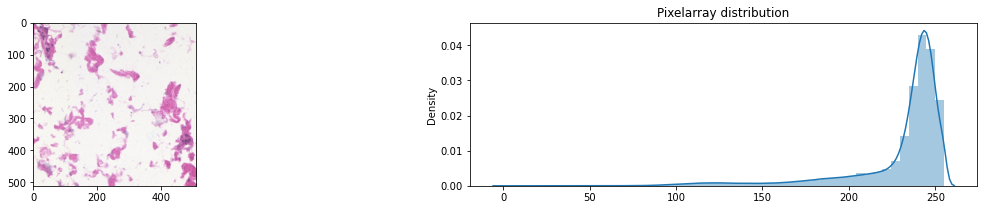

In [17]:
tile = get_tile(baseimage, tile_size, 5, 5)
show_tile_dist(tile)

In [36]:
img_hist = np.histogram(tile)
print('histogram = {}'.format(img_hist[0]))
print('histogram_lowpass = {}'.format(np.sum(img_hist[0][0:4])))

histogram = [     4      5    324   4137  14908  14015  22322  44003  90216 596498]
histogram_lowpass = 4470


##### Step 7 - Get the glomeruli coordinates from json file read before and see that specific tile

##### First glomeruli starts at (12002, 6553) coordinates. We expect to find it in (12002/512, 6553/512) tile, i.e., (23, 12).

C:\Users\soodn\Anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


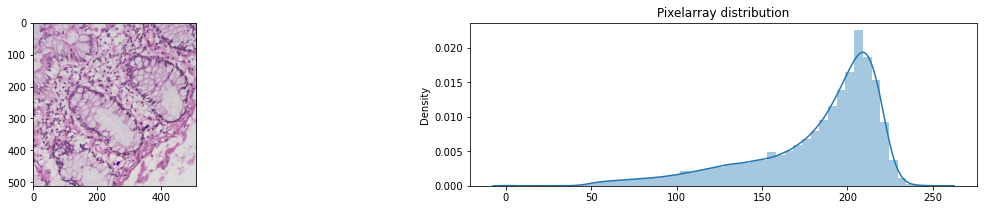

In [18]:
tile = get_tile(baseimage, tile_size, 2, 3)
show_tile_dist(tile)

In [19]:
img_hist = np.histogram(tile)
print('histogram = {}'.format(img_hist[0]))
print('histogram_lowpass = {}'.format(np.sum(img_hist[0][0:4])))

histogram = [   279   1630  15056  25003  46905  67161 107838 238214 278474   5872]
histogram_lowpass = 41968


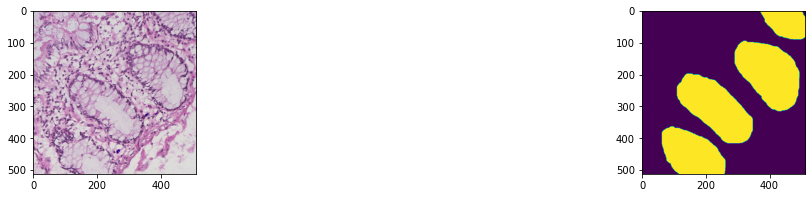

In [20]:
show_tile_and_mask(baseimage, mask, tile_size, 2, 3)

In [21]:
tile_mask = get_tile_mask(mask, tile_size, 2, 3)
mask_density = np.count_nonzero(tile_mask)
mask_density

92138

##### We found our first glomeruli!

##### Step 8 - See a few more tiles

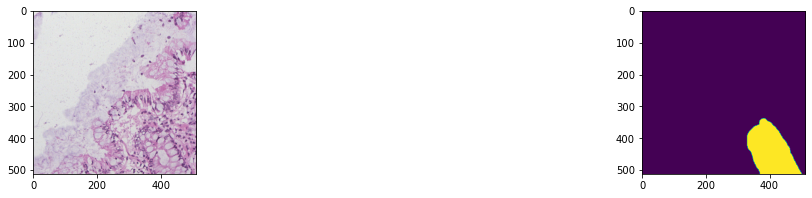

In [22]:
show_tile_and_mask(baseimage, mask, tile_size, 1, 3)

In [23]:
tile_mask = get_tile_mask(mask, tile_size, 3, 3)
mask_density = np.count_nonzero(tile_mask)
mask_density

13408

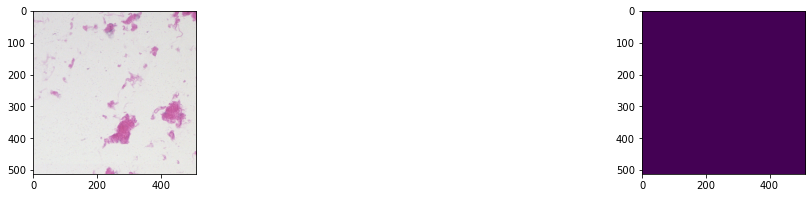

In [24]:
show_tile_and_mask(baseimage, mask, tile_size, 3, 4)

In [25]:
tile_mask = get_tile_mask(mask, tile_size, 14, 23)
mask_density = np.count_nonzero(tile_mask)
mask_density

0

##### Step 9 - Build TFRecords - Writing each tile to a TFRecord file, dataframe to store metadata including low pass energy, mask density.

In [26]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def image_example(image_index, image, mask, tile_id, tile_col_pos, tile_row_pos):
    image_shape = image.shape
    
    img_bytes = image.tostring()

    mask_bytes = mask.tostring()
    
    feature = {
        'img_index': _int64_feature(image_index),
        'height': _int64_feature(image_shape[0]),
        'width': _int64_feature(image_shape[1]),
        'num_channels': _int64_feature(image_shape[2]),
        'img_bytes': _bytes_feature(img_bytes),
        'mask' : _bytes_feature(mask_bytes),
        'tile_id':  _int64_feature(tile_id),
        'tile_col_pos': _int64_feature(tile_col_pos),
        'tile_row_pos': _int64_feature(tile_row_pos),
        
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def create_tfrecord( image_index, image, mask, tile_id, tile_col_pos, tile_row_pos, output_path):
    opts = tf.io.TFRecordOptions(compression_type="GZIP")
    with tf.io.TFRecordWriter(output_path, opts) as writer:
        tf_example = image_example(image_index, image, mask, tile_id, tile_col_pos, tile_row_pos)
        writer.write(tf_example.SerializeToString())
    writer.close()
    
def write_tfrecord_tiles( image_index, image_id, image, mask, tile_size, output_path ):
    output_dir = output_path+image_id
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.mkdir(output_dir)
    
    image_cols = image.shape[0]
    image_rows = image.shape[1]
    tile_cols = image_cols // tile_size
    tile_rows = image_rows // tile_size
    tileID = 0
    
    # create a pandas dataframe to store metadata for each tile
    tile_df = pd.DataFrame(columns = ['img_index', 'img_id','tile_id', 'tile_rel_path','tile_col_num', 'tile_row_num', 'lowband_density', 'mask_density'])
    
    # create one directory for each row of images
    for col_number in range(tile_cols):
        print('col_offset{} '.format(col_number),end='')
        dir_path = output_dir+'/col{}'.format(col_number)
        # create directory
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.mkdir(dir_path)
        for row_number in range(tile_rows):
            #print("row{}".format(row_number),end='')
            dataset_file_path = dir_path+'/col{}_row{}.tfrecords'.format(col_number,row_number)
            relative_path = image_id+'/col{}_row{}.tfrecords'.format(col_number,row_number)
            lower_col_range = col_number * tile_size
            higher_col_range = lower_col_range + tile_size
            lower_row_range = row_number * tile_size
            higher_row_range = lower_row_range + tile_size
            image_tile = image[lower_col_range:higher_col_range, lower_row_range:higher_row_range, :]
            tile_mask = mask[lower_col_range:higher_col_range, lower_row_range:higher_row_range]
            num_records = create_tfrecord( image_index, image_tile, tile_mask, tileID, col_number, row_number, dataset_file_path)
            # populate the metadata for this tile
            img_hist = np.histogram(image_tile)
            lowband_density = np.sum(img_hist[0][0:4])
            mask_density = np.count_nonzero(tile_mask)
            tile_df = tile_df.append({'img_index':image_index, 'img_id':image_id, 'tile_id': tileID, 'tile_rel_path':relative_path, 
                           'tile_col_num':col_number, 'tile_row_num':row_number,'lowband_density':lowband_density, 'mask_density':mask_density},ignore_index=True)
            tileID += 1
    return tile_df


In [27]:
output_dir = 'OutputColon/output_train/'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.mkdir(output_dir)

tile_size = 512
num_images = len(image_ids)

for image_index in range(num_images):
    image_id = image_ids[image_index]
#     image_id = '095bf7a1f'
    image_path = basepath+'/tif images/'+image_id+'.tif'
    image_json_mask =  basepath+'/Annotations/json/'+image_id+'_annotations.json'
    print (image_path)
    baseimage = tifffile.imread(image_path)
    print ('original image shape',baseimage.shape)
    baseimage = np.squeeze(baseimage)
    if( baseimage.shape[0] == 3):
        baseimage = baseimage.swapaxes(0,1)
        baseimage = baseimage.swapaxes(1,2)
        print ('swaped shape',baseimage.shape)
        # read json mask
    if (len(baseimage.shape) == 2):
        baseimage = baseimage.reshape(baseimage.shape[0], baseimage.shape[1], 1)
    mask_shape = (baseimage.shape[0], baseimage.shape[1])
    mask = read_mask(image_json_mask, mask_shape)

    print('writing tiles for image {}'.format(image_id))
    tile_df = write_tfrecord_tiles( image_index, image_id, baseimage, mask, tile_size, output_dir )

    #write the dataframe
    print('writing tile metadata for image {}'.format(image_id))
    df_path = output_dir+image_id+'_tiles.csv'
    tile_df.to_csv(df_path)
    gc.collect()

C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data/tif images/CL_HandE_1234_B004.tif
original image shape (3, 9072, 9408)
swaped shape (9072, 9408, 3)
writing tiles for image CL_HandE_1234_B004
col_offset0 

<ipython-input-26-371d01117989>:18: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  img_bytes = image.tostring()
<ipython-input-26-371d01117989>:20: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  mask_bytes = mask.tostring()


col_offset1 col_offset2 col_offset3 col_offset4 col_offset5 col_offset6 col_offset7 col_offset8 col_offset9 col_offset10 col_offset11 col_offset12 col_offset13 col_offset14 col_offset15 col_offset16 

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


writing tile metadata for image CL_HandE_1234_B004
C:\Users\soodn\Downloads\Naveksha\Kaggle HuBMAP\Data\hubmap_colon_data/tif images/HandE_B005_CL_b_RGB.tif
original image shape (9072, 9408, 3)
writing tiles for image HandE_B005_CL_b_RGB
col_offset0 col_offset1 col_offset2 col_offset3 col_offset4 col_offset5 col_offset6 col_offset7 col_offset8 col_offset9 col_offset10 col_offset11 col_offset12 col_offset13 col_offset14 col_offset15 col_offset16 writing tile metadata for image HandE_B005_CL_b_RGB
